## Import the necessary libraries and packages

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
import pandas as pd
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from bayesian.train_bn import structure_learning, parameter_learning
from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect, direct_train, range_pairs
import seaborn as sns
import numpy as np
from copy import  copy
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN, draw_comparative_hist
import networkx as nx
from pomegranate import log_probability, BayesianNetwork
from external.libpgm.sampleaggregator import SampleAggregator
import operator

Load the necessary data.  
The data was collected from the social network VKontakte using an open API.  
The variables are the following: 
## Socio-demographic data 
`age`  
`sex`  
`city_id` - city code  
`has_high_education`  
`relation` - marital status  
`num_of_relatives` - number of relatives  
...

## Information about interests  
`top1_interes` 
`top2_interes` 
`top3_interes` 
...

## Finance information
`max_tr` - maximum size of transaction  
`mean_tr`  
`cash_usage` 
...

In [32]:
vk_data = pd.read_csv('../data/vk_data.csv')
vk_data.head(10)

,age,sex,city,education_status,relation,relatives,friends_count,followers_count,avg_likes,posts_count,avg_views,repost_ratio
0,36,1.0,1,0,0.0,0,304.0,175.0,4,1735,11,48
1,31,1.0,2,0,0.0,0,277.0,266.0,46,12,256,0
2,0,2.0,2,3,1.0,0,97.0,37.0,1,205,12,4
3,0,1.0,2,0,0.0,0,405.0,399.0,4,2647,11,34
4,30,1.0,2,0,0.0,0,401.0,449.0,7,3221,43,46
5,0,1.0,2,0,0.0,0,73.0,115.0,1,599,29,95
6,0,1.0,1,0,0.0,0,306.0,667.0,4,2471,19,11
7,36,2.0,2,0,0.0,0,194.0,356.0,3,4093,11,73
8,0,1.0,1,0,0.0,0,343.0,252.0,5,304,34,61
9,30,1.0,1,3,0.0,0,237.0,563.0,5,1272,52,75


In [33]:
vk_data['sex'] = vk_data['sex'].apply(lambda x: int(x))
vk_data['age'] = vk_data['age'].apply(lambda x: float(x))
vk_data['posts_count'] = vk_data['posts_count'].apply(lambda x: float(x))
vk_data['relation'] = vk_data['relation'].apply(lambda x: int(x))
vk_data['avg_views'] = vk_data['avg_views'].apply(lambda x: int(x))

In [34]:
vk_data = vk_data.loc[(vk_data['age'] !=0) & (vk_data['sex'] != 0)]
vk_data.reset_index(inplace=True, drop=True)

In [35]:
node_types = get_nodes_type(vk_data)
node_types

{'age': 'cont',
 'sex': 'disc',
 'city': 'disc',
 'education_status': 'disc',
 'relation': 'disc',
 'relatives': 'disc',
 'friends_count': 'cont',
 'followers_count': 'cont',
 'avg_likes': 'disc',
 'posts_count': 'cont',
 'avg_views': 'disc',
 'repost_ratio': 'disc'}

In [36]:
params_for_disc=[
 'age', 'friends_count', 'followers_count', 'posts_count', 'avg_views'
 ]

In [37]:
nodes_sign = get_nodes_sign(vk_data)
nodes_sign

{'age': 'pos',
 'friends_count': 'pos',
 'followers_count': 'pos',
 'posts_count': 'pos'}

In [38]:
data = copy(vk_data)

In [39]:
data

,age,sex,city,education_status,relation,relatives,friends_count,followers_count,avg_likes,posts_count,avg_views,repost_ratio
0,36.0,1,1,0,0,0,304.0,175.0,4,1735.0,11,48
1,31.0,1,2,0,0,0,277.0,266.0,46,12.0,256,0
2,30.0,1,2,0,0,0,401.0,449.0,7,3221.0,43,46
3,36.0,2,2,0,0,0,194.0,356.0,3,4093.0,11,73
4,30.0,1,1,3,0,0,237.0,563.0,5,1272.0,52,75
...,...,...,...,...,...,...,...,...,...,...,...,...
14391,23.0,2,1,0,0,0,246.0,280.0,46,14.0,686,15
14392,28.0,1,1,0,0,0,179.0,151.0,6,481.0,39,84
14393,27.0,2,104,0,0,0,49.0,38.0,3,62.0,0,88
14394,18.0,2,1,0,0,0,108.0,8.0,1,445.0,3,94


In [40]:
discrete, est = discretization(data , 'equal_frequency', bins= 5, columns=params_for_disc)

In [41]:
discrete

,age,sex,city,education_status,relation,relatives,friends_count,followers_count,avg_likes,posts_count,avg_views,repost_ratio
0,4,1,1,0,0,0,3,2,4,3,1,48
1,3,1,2,0,0,0,3,3,46,0,3,0
2,3,1,2,0,0,0,4,4,7,4,2,46
3,4,2,2,0,0,0,3,3,3,4,1,73
4,3,1,1,3,0,0,3,4,5,3,2,75
...,...,...,...,...,...,...,...,...,...,...,...,...
14391,2,2,1,0,0,0,3,3,46,1,4,15
14392,3,1,1,0,0,0,2,2,6,2,2,84
14393,3,2,104,0,0,0,0,0,3,1,0,88
14394,0,2,1,0,0,0,1,0,1,2,0,94


In [42]:
start = time.time()
bn = structure_learning(discrete, 'HC', node_types, 'K2')
param = parameter_learning(data, node_types, bn, 'simple')
end = time.time()
print(end - start)

  0%|          | 18/1000000 [00:03<60:03:37,  4.62it/s]
114.96240329742432


In [43]:
save_structure(bn, 'full_net')
skel = read_structure('full_net')
save_params(param, 'full_net_param')
params = read_params('full_net_param')
full = HyBayesianNetwork(skel, params)

In [25]:
draw_BN(bn, node_types, 'vk_net')

In [67]:
evid={'age': 25}

In [44]:
full.randomsample(1000,'simple')

llowers_count': 239.0,
  'age': 43.9370054327933,
  'city': '10'},
 {'avg_likes': '123',
  'avg_views': '885',
  'repost_ratio': '0',
  'posts_count': 2.285742575546115,
  'friends_count': 185.50132810651363,
  'relatives': '0',
  'education_status': '0',
  'relation': '0',
  'sex': '1',
  'followers_count': 127.63425232267194,
  'age': 10.555766139983895,
  'city': '5096'},
 {'avg_likes': '10',
  'avg_views': '11',
  'repost_ratio': '85',
  'posts_count': 2094.2837751470006,
  'friends_count': 119.61576531989476,
  'relatives': '0',
  'education_status': '0',
  'relation': '0',
  'sex': '1',
  'followers_count': -142.1052624411936,
  'age': 25.561305265022217,
  'city': '10'},
 {'avg_likes': '106',
  'avg_views': '958',
  'repost_ratio': '23',
  'posts_count': nan,
  'friends_count': nan,
  'relatives': '0',
  'education_status': '0',
  'relation': '0',
  'sex': '2',
  'followers_count': nan,
  'age': nan,
  'city': '1'},
 {'avg_likes': '142',
  'avg_views': '893',
  'repost_ratio': '

In [45]:
generate_synthetics(full,nodes_sign,'simple',1000)

,avg_likes,avg_views,repost_ratio,posts_count,friends_count,relatives,education_status,relation,sex,followers_count,age,city
0,101,50,55,301.000000,196.688510,0,3,7,1,304.015618,21.554651,10
1,101,50,80,425.000000,335.101054,13,0,5,1,428.806490,48.133457,1122042
2,100,613,0,10.875643,289.878645,0,0,0,1,251.346747,11.570313,1
3,100,613,0,8.300407,202.470154,0,0,1,1,298.855233,18.569687,10
4,133,521,0,3.000000,125.875066,1,0,1,1,173.338816,23.089899,10
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,56,203.732581,1317.715307,1,0,0,1,254.257670,36.928779,130
996,10,1134,0,3.000000,85.000000,0,0,0,2,164.000000,10.832538,1
997,100,613,0,19.078567,510.877518,0,0,0,1,334.127979,49.250244,1
998,115,808,0,14.000000,99.172029,0,0,0,1,618.809083,34.609808,1158


In [21]:
start = time.time()
bn1 = structure_learning(module1_d, 'HC', node_type1, 'K2')

NameError: name 'module1_d' is not defined

In [24]:
bn1

{'V': ['age', 'sex', 'has_high_education', 'relation', 'num_of_relatives'],
 'E': [['sex', 'age'],
  ['has_high_education', 'age'],
  ['relation', 'has_high_education'],
  ['relation', 'age'],
  ['relation', 'sex'],
  ['num_of_relatives', 'relation'],
  ['num_of_relatives', 'has_high_education']]}

In [22]:
draw_BN(bn1, node_type1, 'module1')

In [16]:
param1 = parameter_learning(module1, node_type1, bn1)

In [17]:
save_structure(bn1, 'skel1')
skel1 = read_structure('skel1')
save_params(param1, 'params1')
params1 = read_params('params1')
hybn1 = HyBayesianNetwork(skel1, params1)

In [18]:
bn2 = structure_learning(module2_d, 'HC', node_type2, 'K2')

  0%|          | 4/1000000 [00:00<25:35:45, 10.85it/s]


In [30]:
bn2

{'V': ['about', 'activities', 'books', 'interests', 'movies'],
 'E': [['books', 'movies'],
  ['interests', 'activities'],
  ['movies', 'interests'],
  ['movies', 'about']]}

In [31]:
draw_BN(bn2, node_type2, 'module2')

In [19]:
param2 = parameter_learning(module2, node_type2, bn2)

In [20]:
save_structure(bn2, 'skel2')
skel2 = read_structure('skel2')
save_params(param2, 'params2')
params2 = read_params('params2')
hybn2 = HyBayesianNetwork(skel2, params2)

In [35]:
end = time.time()
print(end - start)

2.421198844909668


In [21]:
bn3 = structure_learning(module3_d, 'HC', node_type3, 'K2')
bn3

  0%|          | 5/1000000 [00:00<31:40:49,  8.77it/s]


{'V': ['top1_interes',
  'top2_interes',
  'top3_interes',
  'top4_interes',
  'top5_interes'],
 'E': [['top1_interes', 'top2_interes'],
  ['top1_interes', 'top3_interes'],
  ['top1_interes', 'top4_interes'],
  ['top1_interes', 'top5_interes'],
  ['top2_interes', 'top3_interes']]}

In [36]:
draw_BN(bn3, node_type3, 'module3')

In [22]:
param3 = parameter_learning(module3, node_type3, bn3)

In [23]:
save_structure(bn3, 'skel3')
skel3 = read_structure('skel3')
save_params(param3, 'params3')
params3 = read_params('params3')
hybn3 = HyBayesianNetwork(skel3, params3)

In [42]:
end = time.time()
print(end - start)

3.4464473724365234


In [24]:
bn4 = structure_learning(module4_d, 'HC', node_type4, 'K2')
bn4

  0%|          | 13/1000000 [00:00<10:21:47, 26.80it/s]


{'V': ['max_tr',
  'mean_tr',
  'is_parent',
  'is_driver',
  'has_pets',
  'cash_usage'],
 'E': [['mean_tr', 'max_tr'],
  ['is_parent', 'mean_tr'],
  ['is_parent', 'max_tr'],
  ['is_driver', 'mean_tr'],
  ['is_driver', 'is_parent'],
  ['has_pets', 'mean_tr'],
  ['has_pets', 'cash_usage'],
  ['has_pets', 'is_parent'],
  ['cash_usage', 'max_tr'],
  ['cash_usage', 'is_parent'],
  ['cash_usage', 'mean_tr'],
  ['cash_usage', 'is_driver']]}

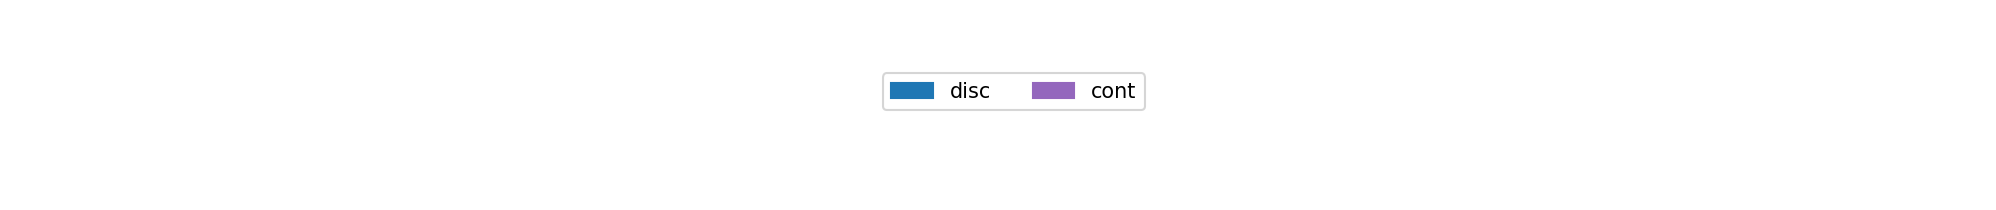

In [46]:
draw_BN(bn4, node_type4, 'module4')

In [25]:
param4 = parameter_learning(module4, node_type4, bn4)

In [26]:
save_structure(bn4, 'skel4')
skel4 = read_structure('skel4')
save_params(param4, 'params4')
params4 = read_params('params4')
hybn4 = HyBayesianNetwork(skel4, params4)

In [49]:
end = time.time()
print(end - start)

5.370755910873413


In [27]:
hybn_connect = direct_connect([bn1,bn2, bn3, bn4], discrete, node_types)

  0%|          | 33/1000000 [00:09<84:05:38,  3.30it/s]['0 1', '0 2', '0 3']



In [28]:
hybns = [bn1,bn2, bn3, bn4]

In [31]:
hybn_final = direct_train(hybns, coded_data, hybn_connect)

0 1
0 2
0 3


In [67]:
end = time.time()
print(end - start)

220.57396340370178


In [68]:
final_struct = dict()
final_struct['V'] = hybn_final.V
final_struct['E'] = hybn_final.E

In [69]:
final_struct['V'] 

['relation_status',
 'has_high_education',
 'number_of_relatives',
 'age',
 'sex',
 'L 0_1',
 'number_of_activities',
 'number_of_interests',
 'number_of_movies',
 'number_of_books',
 'len_of_about',
 'L 1_3',
 'L 0_2',
 'L 0_4',
 'cash_usage',
 'parent',
 'driver',
 'has_pets',
 'L 4_2',
 'mean_tr',
 'max_tr',
 'L 0_3',
 'nodes',
 'L 3_2',
 'top1',
 'top2',
 'top3',
 'top4',
 'degree_assortativity_coefficient',
 'eigenvector_centrality',
 'betweenness_centrality',
 'density']

In [70]:
final_struct['E']

[['top1', 'top3'],
 ['driver', 'max_tr'],
 ['number_of_movies', 'number_of_books'],
 ['number_of_activities', 'number_of_interests'],
 ['number_of_relatives', 'L 0_3'],
 ['eigenvector_centrality', 'betweenness_centrality'],
 ['has_pets', 'L 4_2'],
 ['cash_usage', 'mean_tr'],
 ['number_of_relatives', 'L 0_2'],
 ['nodes', 'L 3_2'],
 ['mean_tr', 'max_tr'],
 ['nodes', 'density'],
 ['L 0_1', 'number_of_activities'],
 ['parent', 'max_tr'],
 ['top3', 'top4'],
 ['L 0_2', 'top1'],
 ['top2', 'top3'],
 ['parent', 'driver'],
 ['L 4_2', 'top1'],
 ['sex', 'L 0_1'],
 ['sex', 'L 0_2'],
 ['number_of_relatives', 'L 0_4'],
 ['nodes', 'degree_assortativity_coefficient'],
 ['has_pets', 'mean_tr'],
 ['degree_assortativity_coefficient', 'betweenness_centrality'],
 ['cash_usage', 'driver'],
 ['top1', 'top2'],
 ['number_of_relatives', 'L 0_1'],
 ['has_high_education', 'number_of_relatives'],
 ['sex', 'L 0_4'],
 ['parent', 'has_pets'],
 ['parent', 'L 4_2'],
 ['top2', 'top4'],
 ['age', 'sex'],
 ['cash_usage', 'p

In [28]:
sample = generate_synthetics(hybn_final, nodes_sign)

NameError: name 'hybn_final' is not defined

In [58]:
sample = generate_synthetics(bn, nodes_sign, 'simple', 400)

AttributeError: 'dict' object has no attribute 'randomsample'

In [33]:
sample

,num_of_relatives,relation,sex,has_high_education,L 0_1,books,movies,about,interests,activities,...,top3_interes,top5_interes,top4_interes,L 0_3,has_pets,cash_usage,is_driver,is_parent,mean_tr,max_tr
0,10,1,2,0,2,0,0,0,0,0,...,15,0,13,2,0,1,0,0,8460.253261,264342.559592
1,116,0,1,1,2,1,1,117,0,0,...,16,13,16,0,0,1,0,0,20014.273942,86088.403806
2,10,1,1,0,2,0,0,0,0,0,...,14,16,22,0,0,1,0,1,2400.701858,52445.257798
3,10,4,1,1,0,0,0,0,0,0,...,25,8,13,1,0,1,0,0,973.293207,251236.378272
4,10,4,1,0,0,13,0,0,0,0,...,14,9,7,1,0,1,0,1,12284.878462,319384.379049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10,4,2,0,0,0,0,0,0,0,...,13,15,0,1,0,1,0,0,3744.816356,82432.211069
996,10,0,1,1,1,18,1,1,1,14,...,15,11,9,0,0,0,0,0,8842.612141,40145.780343
997,10,4,2,0,0,0,0,0,0,0,...,19,22,18,1,1,1,0,1,1148.524609,33768.210815
998,117,0,1,0,2,0,0,100,0,0,...,11,5,18,0,1,1,0,0,1065.107618,8779.735464
